# **iSIM**

***
Miranda-Quintana Group, Department of Chemistry, University of Florida

***
Please cite the original iSIM paper:

***
This notebook contains an example on how to generate binary and real-value descriptor fingerprints and apply iSIM to them. The example shows how to download one of the datasets studied on the paper. 

Other functionalities like complementary similarity, identification of medoids and outliers are shown. 

In [16]:
from iSIM.comp import calculate_isim, calculate_medoid, calculate_outlier
from iSIM.real import calculate_isim_real, calculate_medoid_real, calculate_outlier_real, pairwise_average_real
from iSIM.utils import binary_fps, minmax_norm, real_fps, pairwise_average, rdkit_pairwise_sim
import numpy as np
import os
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw

## Generation of binary fingerprints
This example shows how to download one of the datasets used in the paper. If other dataset wants to be tested please change the name accordingly, to see the dataset names refer to paper SI. 

The databases are available at: https://github.com/molML/MoleculeACE/blob/main/MoleculeACE/Data/benchmark_data/old/

Please cite the original paper where the databases were cured:
Exposing the Limitations of Molecular Machine Learning with Activity Cliffs. Derek van Tilborg, Alisa Alenicheva, and Francesca Grisoni. 
Journal of Chemical Information and Modeling, 2022, 62 (23), 5938-5951. DOI: 10.1021/acs.jcim.2c01073

### Downloading one of the used datasets from the github repo

In [3]:
git_path = 'https://raw.githubusercontent.com/molML/MoleculeACE/main/MoleculeACE/Data/benchmark_data/old/'


### Desired dataset 
dataset = 'CHEMBL214_Ki.csv'

### Download the dataset
os.system('wget ' + git_path + dataset)

--2024-04-15 21:51:10--  https://raw.githubusercontent.com/molML/MoleculeACE/main/MoleculeACE/Data/benchmark_data/old/CHEMBL214_Ki.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 266241 (260K) [text/plain]
Saving to: ‘CHEMBL214_Ki.csv’

     0K .......... .......... .......... .......... .......... 19% 3.83M 0s
    50K .......... .......... .......... .......... .......... 38% 3.87M 0s
   100K .......... .......... .......... .......... .......... 57% 9.74M 0s
   150K .......... .......... .......... .......... .......... 76% 8.73M 0s
   200K .......... .......... .......... .......... .......... 96% 37.3M 0s
   250K ..........                                            100%  376M=0.04s

2024-04-15 21:51:11 (6.81 MB/s) - ‘CHEMBL214_Ki.csv’ saved [266241/

0

### Reading the .csv file and generating binary fingerprints

In [2]:
# This is step is only necesary if you do not have your data as fingerprints
dataset = 'CHEMBL214_Ki.csv'

# Read the SMILES from a csv file
df = pd.read_csv(dataset) # --> This file contains the smiles of the molecules, change it for your own data
smiles = df['smiles'].tolist() # --> This is a list of smiles, change column name for your own data

# Generation of fingerprints
fps = binary_fps(smiles, fp_type='RDKIT', n_bits=None) # --> fp_type: {'RDKIT', 'ECFP4', 'ECFP6', 'MACCS'}, if ECFP indicate n_bits

# Optional: save the fingerprints in a npy file
np.save(dataset[:-4] +'_fps.npy', fps)    

### Optional: load a .npy file with the binary fingerprints

In [4]:
# Load the fingerprints from a npy file (optional, in case you have already generated the fingerprints)
# fps = np.load('fps_iSIM_example.npy', allow_pickle=True)

# Calculation of iSIM

In [3]:
index = 'JT' # --> Change to JT, RR or SM
print(f'Number of molecules: {len(fps)}')

Number of molecules: 3317


In [4]:
%%time
isim = calculate_isim(fps, n_ary = index)
print(f'iSIM: {isim:.5f}')

iSIM: 0.33036
CPU times: user 5.7 ms, sys: 208 µs, total: 5.9 ms
Wall time: 4.88 ms


Calculation of the average pairwise similarity
Approach using only numpy fuctions (iSIM only uses numpy functions)

In [9]:
%%time
print(f'Average pairwise similarity: {pairwise_average(fingerprints=fps, n_ary=index):.5f}')

Average pairwise similarity: 0.32487
CPU times: user 6min 38s, sys: 445 ms, total: 6min 38s
Wall time: 6min 38s


Calculation using rdkit bulk similarity functions

In [5]:
# Convert the fingerprints to ExplicitBitVect format required by RDKit
fps_bitvect = []
for fp in fps:
    bitvect = DataStructs.ExplicitBitVect(len(fp))
    bitvect.SetBitsFromList(np.where(fp)[0].tolist())
    fps_bitvect.append(bitvect)

In [6]:
%%time
average_pairwise = rdkit_pairwise_sim(fps_bitvect)
print(f'Average pairwise similarity: {average_pairwise:.5f}')

Average pairwise similarity: 0.32487
CPU times: user 930 ms, sys: 116 ms, total: 1.05 s
Wall time: 1.04 s


### Get the medoid 

Most similar molecule to the rest of the molecules

*To get the drawing smiles is necessary

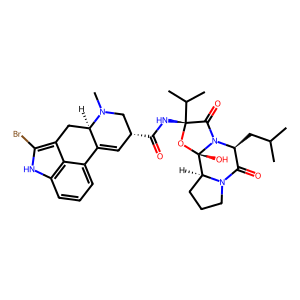

In [7]:
medoid = calculate_medoid(fps, n_ary = index)
mol = Chem.MolFromSmiles(smiles[medoid])
Draw.MolToImage(mol)

### Get the outlier

Most dissimilar molecules to the rest of the molecules

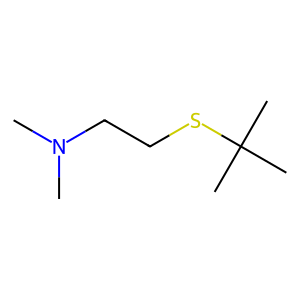

In [8]:
outlier = calculate_outlier(fps, n_ary = index)
mol = Chem.MolFromSmiles(smiles[outlier])
Draw.MolToImage(mol)

# Generation of real-value descriptor fingerprints

Generation of rdkit real-value descriptors. Descriptors with errors from rdkit dropped. 

Normalization of the fingerprints is required. You can substitute by any method that normalizes between [0, 1]

In [19]:
fps_real = real_fps(smiles)
fps_real = minmax_norm(fps_real)

/home/kenneth/Documents/iSIM/isim_utils.py:137: RuntimeWarning: invalid value encountered in scalar divide
  df[column] = [(x - min_prop) / (max_prop - min_prop) for x in df[column]]


Calculation of iSIM for real value descriptors

In [26]:
%%time
index = 'JT' # --> Change JT, RR or SM
print(f'iSIM: {calculate_isim_real(fps_real, n_ary = index):.5f}')

iSIM: 0.67973
CPU times: user 2.9 ms, sys: 0 ns, total: 2.9 ms
Wall time: 2 ms


Calculation of the average pairwise similarity using only numpy functions (O(N^2))

In [27]:
%%time
print(f'Average pairwise similarity: {pairwise_average_real(fingerprints=fps_real, n_ary=index):.5f}')

Average pairwise similarity: 0.68718
CPU times: user 1min 1s, sys: 288 ms, total: 1min 1s
Wall time: 1min 1s


### Get the medoid using real-value descriptors

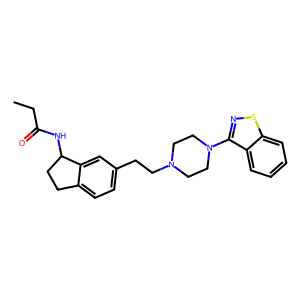

In [28]:
medoid = calculate_medoid_real(fps_real, n_ary = index)
mol = Chem.MolFromSmiles(smiles[medoid])
Draw.MolToImage(mol)

### Get the outlier using real-value descriptors

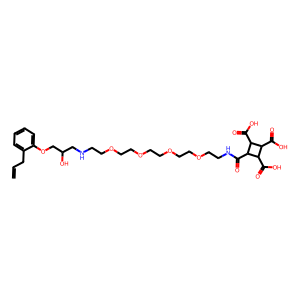

In [29]:
outlier = calculate_outlier(fps_real, n_ary = index)
mol = Chem.MolFromSmiles(smiles[outlier])
Draw.MolToImage(mol)